独热向量不能准确表达不同词之间的相似度

word2vec：将每个词映射到固定长度的向量，这些向量能更好的表达不同词之间的相似性和类比关系

word2vec工具包含两个模型，即跳元模型（skip-gram）和连续词袋（CBOW）

跳元模型假设一个单词可用于在文本序列中，生成其周围的单词；而连续词袋模型假设基于上下文词来生成中心单词。

In [1]:
import collections
import math
import os
import random
import torch
from d2l import torch as d2l

In [2]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    data_dir = d2l.download_extract('ptb')
    # Readthetrainingset.
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences数: {len(sentences)}'

'# sentences数: 42069'

In [3]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

In [4]:
#@save
def count_corpus(tokens): 
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [7]:
# 对“the", "a" 等高频单词进行下采样， 数据集中的每个词w将有概率地被丢弃
#@save
def subsample(sentences, vocab):
    """ 下采样高频词 """
    # 排除未知词元<unk>
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                  for line in sentences]
    counter = count_corpus(sentences)
    num_tokens = sum(counter.values())
    
    # 如果在下采样期间保留词元， 则返回True
    def keep(token):
        return (random.uniform(0, 1) < math.sqrt(1e-4 / counter[token] * num_tokens))
    
    return ([[token for token in line if keep(token)] for line in sentences], counter)

In [8]:
subsampled, counter = subsample(sentences, vocab)

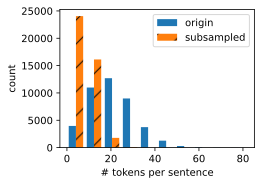

In [20]:
d2l.show_list_len_pair_hist(
    ['origin', 'subsampled'], '# tokens per sentence',
    'count', sentences, subsampled);

In [23]:
def compare_counts(token):
    return (f'"{token}"的数量：'
            f'之前={sum([l.count(token) for l in sentences])}, '
            f'之后={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'"the"的数量：之前=50770, 之后=2054'

In [24]:
compare_counts('join')

'"join"的数量：之前=45, 之后=45'

In [34]:
# 将词元映射到它们在语料库中的索引
corpus = [vocab[line] for line in subsampled]
print(len(corpus))
corpus[:3]

42069


[[], [3228, 1773, 4060], [993, 3922, 1922, 4743]]

In [35]:
subsampled[:3]

[[], ['join', 'director', 'nov.'], ['chairman', 'n.v.', 'dutch', 'publishing']]

In [47]:
# 中心词和上下文词的提取
#@save
def get_centers_and_contexts(corpus, max_window_size):
    """ 返回跳元模型的中心词和上下文词 """
    centers, contexts = [], []
    counter = 0
    for line in corpus:
        # 要形成“中心词-上下文词”对，每个句子至少需要两个词
        if len(line) < 2:
            counter += 1
            continue
        centers += line
        for i in range(len(line)):  # 上下文窗口中间i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # 从上下文词中排除中心词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [48]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中心词', center, '的上下文词是', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中心词 0 的上下文词是 [1, 2]
中心词 1 的上下文词是 [0, 2]
中心词 2 的上下文词是 [0, 1, 3, 4]
中心词 3 的上下文词是 [2, 4]
中心词 4 的上下文词是 [2, 3, 5, 6]
中心词 5 的上下文词是 [4, 6]
中心词 6 的上下文词是 [4, 5]
中心词 7 的上下文词是 [8]
中心词 8 的上下文词是 [7, 9]
中心词 9 的上下文词是 [7, 8]


In [49]:
print(len(corpus))
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
print(len(all_centers))
print(f'# “中心词-上下文词对”的数量: {sum([len(contexts) for contexts in all_contexts])}')

42069
342568
# “中心词-上下文词对”的数量: 1500502


In [50]:
# 使用负采样进行近似训练
#@save
class RandomGenerator:
    """ 根据n个采样权重在{1, ..., n}中随机抽取 """
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0
        
    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [56]:
#@save
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[1, 3, 1, 2, 2, 3, 3, 3, 2, 1]

In [57]:
# 负采样：添加多个负样本进行计算
#@save
def get_negatives(all_contexts, vocab, counter, K):
    """ 返回负采样中的噪声词 """
    sampling_weights = [counter[vocab.to_tokens(i)] ** 0.75 for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # 噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

In [58]:
# 小批量样本：第i个样本包括中心词及其n个上下文词和m个噪声词
# 由于上下文窗口不同，所以不同样本的 n + m不一样
# 进行填充及掩模操作
#@save
def batchify(data):
    """ 返回带有负采样的跳元模型的小批量样本 """
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [59]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [61]:
#@save
class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives

    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index],
                self.negatives[index])

    def __len__(self):
        return len(self.centers)

#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    # num_workers = d2l.get_dataloader_workers()
    num_workers = 0
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)
    
    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify, num_workers=num_workers)
    return data_iter, vocab

In [62]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


In [64]:
from torch import nn

# 跳元模型：使用嵌入层和批量矩阵乘法实现跳元模型
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [65]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[ 0.7296,  0.7168,  0.9037, -0.9966],
         [-0.5241, -1.1438, -0.4472, -0.3387],
         [-0.5445,  0.4146,  0.2688, -1.0566]],

        [[-0.0776,  1.9870, -1.3529,  0.7210],
         [-0.8113, -1.8175,  0.8436,  0.3372],
         [ 0.7200, -0.0915,  0.5029,  1.8361]]], grad_fn=<EmbeddingBackward0>)

In [66]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [67]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [68]:
# 二元交叉熵损失
class SigmoidBCELoss(nn.Module):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)
    
loss = SigmoidBCELoss()

In [69]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [70]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

In [71]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # 规范化的损失之和，规范化的损失数
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.410, 104123.8 tokens/sec on cuda:0


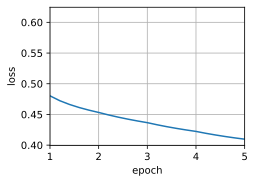

In [72]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

In [74]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # 计算余弦相似性，增加1e-9以获得数值稳定性
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # 删除输入词
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')
        
get_similar_tokens('chip', 3, net[0])

cosine sim=0.749: microprocessor
cosine sim=0.731: intel
cosine sim=0.641: computer
